# Model Training

### Import Data And Required Libraries

In [31]:
# Basic import
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor

Importing Dataset as `pdDataFrame`

In [2]:
# reading the dataset as pdDataFrame
df = pd.read_csv('StudentsPerformance.csv')

# Looking at top 5 rows of dataset
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### Preparing X and Y variable

In [5]:
X = df.drop("math score", axis=1)
X.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [7]:
# Print unique categories in the 'gender' variable
print("Categories in 'gender' variable:     ", end=" ")
print(df['gender'].unique())

# Print unique categories in the 'race_ethnicity' variable
print("Categories in 'race_ethnicity' variable:  ", end=" ")
print(df['race/ethnicity'].unique())

# Print unique categories in the 'parental level of education' variable
print("Categories in 'parental level of education' variable:", end=" ")
print(df['parental level of education'].unique())

# Print unique categories in the 'lunch' variable
print("Categories in 'lunch' variable:     ", end=" ")
print(df['lunch'].unique())

# Print unique categories in the 'test preparation course' variable
print("Categories in 'test preparation course' variable:     ", end=" ")
print(df['test preparation course'].unique())

Categories in 'gender' variable:      ['female' 'male']
Categories in 'race_ethnicity' variable:   ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in 'parental level of education' variable: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch' variable:      ['standard' 'free/reduced']
Categories in 'test preparation course' variable:      ['none' 'completed']


In [8]:
y = df['math score']
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math score, Length: 1000, dtype: int64

### Test Train Split

In [14]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((800, 7), (200, 7))

### Data Preprocessing: Standardization & One-Hot Encoding

In [15]:
# Select numerical and categorical columns from the dataset
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

# Import necessary transformers and tools from sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Define the numeric transformer: StandardScaler for normalizing numerical features
numeric_transformer = StandardScaler()

# Define the categorical transformer: OneHotEncoder for encoding categorical features, with drop='first' to avoid multicollinearity
oh_transformer = OneHotEncoder(drop='first')

# Create the ColumnTransformer that applies transformations to the respective columns
preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),  # Apply OneHotEncoder to categorical features
        ("StandardScaler", numeric_transformer, num_features),  # Apply StandardScaler to numerical features
    ]
)


In [16]:
X_train = preprocessor.fit_transform(X_train)

X_train.shape

(800, 14)

In [17]:
X_test = preprocessor.transform(X_test)

X_test.shape

(200, 14)

**Note:** It is crucial to perform the train-test split before applying any preprocessing steps to the data. This ensures that the test data remains unseen during the training process, preventing **data leakage**. Data leakage can occur when information from the test set influences the training process, leading to overly optimistic performance estimates. By splitting the data first, you ensure that preprocessing steps like scaling, encoding, and imputation are based solely on the training data and are applied consistently to both the training and test sets.


### Custom Function for Evaluating ML Model Performance

In [19]:
def evaluate_metrics(true, preds):
    """
    Evaluates regression model performance by calculating key metrics.

    Parameters:
    true (array-like): The true values of the target variable.
    preds (array-like): The predicted values from the model.

    Returns:
    tuple: A tuple containing the following metrics:
        - mae (float): Mean Absolute Error
        - rmse (float): Root Mean Squared Error
        - r_sqr (float): R-squared (Coefficient of Determination)
    """
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(true, preds)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(true, preds)
    
    # Calculate Root Mean Squared Error (RMSE) by taking the square root of MSE
    rmse = np.sqrt(mse)
    
    # Calculate R-squared (R^2) to measure the goodness of fit
    r_sqr = r2_score(true, preds)

    # Return the calculated metrics as a tuple
    return mae, rmse, r_sqr


### Evaluating Multiple Regression Models: Training and Test Performance Metrics

In [23]:
# Dictionary of models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "AdaBoost Regressor": AdaBoostRegressor()
}

# List to store evaluation metrics for each model
model_list = []

# Loop through each model in the dictionary
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)  # Train the model on the training data

    # Make predictions on both training and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate performance metrics for the training data
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_metrics(y_train, y_train_pred)

    # Evaluate performance metrics for the test data
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_metrics(y_test, y_test_pred)

    # Store the model name and its test performance metrics in a dictionary
    model_dict = {
        'Model Name': list(models.keys())[i],
        "R2 Score": model_test_r2,
        "Mean Absolute Error": model_test_mae,
        "Root Mean Squared Error": model_test_rmse
    }

    # Append the metrics to the model list
    model_list.append(model_dict)
    
    # Print the model name
    print(list(models.keys())[i])
    
    # Print the performance metrics for the training set
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    # Print the performance metrics for the test set
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    
    print('='*35)
    print('\n')  # Print a new line for better readability between model outputs


Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.3231
- Mean Absolute Error: 4.2667
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3940
- Mean Absolute Error: 4.2148
- R2 Score: 0.8804


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.5925
- Mean Absolute Error: 5.2053
- R2 Score: 0.8072
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.5173
- Mean Absolute Error: 5.1557
- R2 Score: 0.8254


Ridge
Model performance for Training set
- Root Mean Squared Error: 5.3235
- Mean Absolute Error: 4.2650
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3936
- Mean Absolute Error: 4.2125
- R2 Score: 0.8805


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5.5719
- Mean Absolute Error: 4.4595
- R2 Score: 0.8623
-----------------------

### Results

In [24]:
# Convert the list of model metrics into a DataFrame and sort by R² Score in descending order
result_df = pd.DataFrame(model_list).sort_values(by='R2 Score', ascending=False)

# Display the sorted DataFrame
result_df


,Model Name,R2 Score,Mean Absolute Error,Root Mean Squared Error
2,Ridge,0.880450,4.212527,5.393615
0,Linear Regression,0.880433,4.214763,5.393994
5,Random Forest Regressor,0.851069,4.690762,6.020022
7,AdaBoost Regressor,0.847396,4.741643,6.093800
1,Lasso,0.825446,5.155720,6.517347
6,XGBRegressor,0.825046,5.078543,6.524809
3,K-Neighbors Regressor,0.777305,5.703000,7.361399
4,Decision Tree,0.728691,6.490000,8.125269


**Insights**
- **Top Performers:** Ridge Regression and Linear Regression offer the best performance with the highest R² scores and lowest RMSE values.

- **Ensemble Methods:** Random Forest and AdaBoost show strong performance but with slightly higher MAE and RMSE compared to Ridge and Linear Regression.

- **Regularization:** Lasso Regression provides good results, though it slightly lags behind Ridge in R² score.

- **Lower Performers:** K-Neighbors and Decision Tree regressors have lower R² scores and higher error metrics, indicating less effective predictions.

### Hyperparameter Tuning of Ridge Regression Using GridsearchCV

In [32]:
alpha_values = np.logspace(-4, 4, 50)

# Define parameter distribution for RandomizedSearchCV
param_grid = {
    'alpha': alpha_values,
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# Initialize Ridge Regression
ridge = Ridge()


# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
model_param = grid_search.best_params_

print(f"---------------- Best Params for model -------------------")
print(model_param)

---------------- Best Params for model -------------------
{'alpha': 1.2067926406393288, 'solver': 'saga'}


### Training and Evaluating Our Model with Optimal Parameters

After tuning hyperparameters for Ridge Regression, the best parameters identified are:

- **Solver**: `saga`
- **Alpha**: `1.2068`

In [33]:
model = Ridge(alpha=1.2068, solver='saga')

model.fit(X_train, y_train)

y_preds = model.predict(X_test)

model_mae, model_rmse, model_r2 = evaluate_metrics(y_test, y_preds)

 # Print the performance metrics for the test set
print('Model performance for Test set')
print("- Root Mean Squared Error: {:.4f}".format(model_rmse))
print("- Mean Absolute Error: {:.4f}".format(model_mae))
print("- R2 Score: {:.4f}".format(model_r2))

Model performance for Test set
- Root Mean Squared Error: 5.3938
- Mean Absolute Error: 4.2123
- R2 Score: 0.8804


**Insight:**
- The model demonstrates robustness as the performance metrics remain consistent before and after hyperparameter tuning. This suggests that the model is already well-optimized with the default parameters and shows minimal sensitivity to the parameter changes explored during tuning.


### Visual Analysis of Model Performance and Residuals

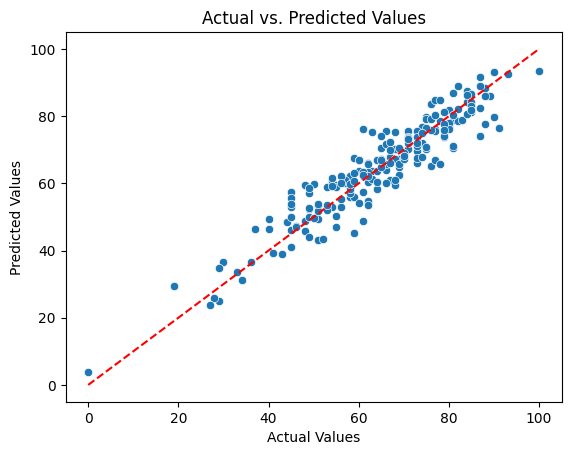

In [50]:
sns.scatterplot(x=y_test, y=y_preds)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

**Insight:**

The plot of actual vs. predicted values shows most points close to the 45-degree line, indicating that the Ridge Regression model is performing well with high prediction accuracy and minimal errors. The linear pattern suggests the model effectively captures the relationship between predictors and the target variable.

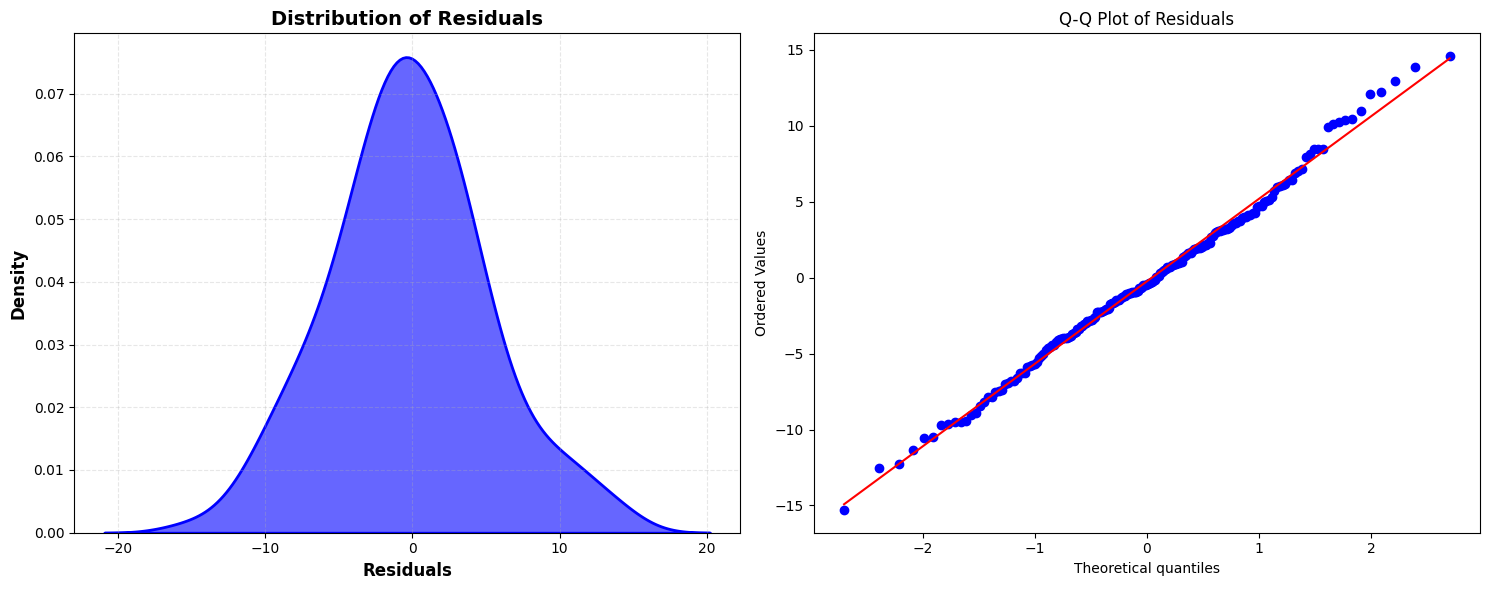

In [48]:
# Compute residuals
residuals = y_test - y_preds

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
# Plot KDE of residuals
sns.kdeplot(residuals, fill=True, color='blue', alpha=0.6, linewidth=2)

# Add titles and labels
plt.title('Distribution of Residuals', fontsize=14, fontweight='bold')
plt.xlabel('Residuals', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold')

# Show grid for better readability
plt.grid(True, linestyle='--', alpha=0.3)


import scipy.stats as stats
plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals', fontweight='bold')
# Display the plot
plt.tight_layout()
plt.show()

**Insights:**

- Normal Distribution: Residuals are normally distributed with a mean of zero, indicating that the model's errors are random and the fit is appropriate.

- No Bias: The centered residuals suggest there’s no systematic bias in predictions.

- Consistent Errors: The spread of residuals is consistent, showing uniform performance across different prediction levels.

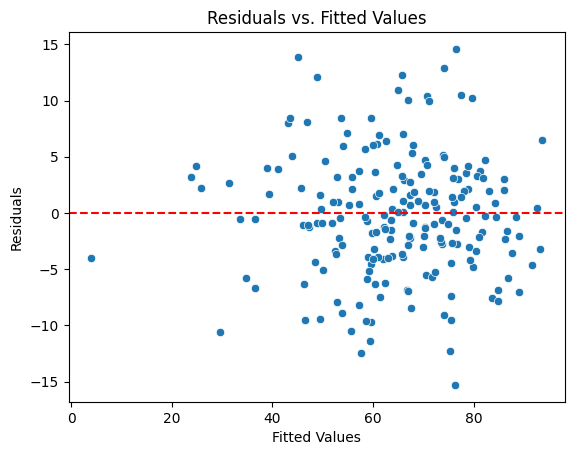

In [49]:
sns.scatterplot(x=y_preds, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

**Insight**

The residuals vs. fitted values plot shows no discernible pattern, indicating that the Ridge Regression model is performing well. The residuals are randomly scattered around zero, suggesting:

- **Good Model Fit**: The model's predictions align well with the actual data.
- **No Systematic Bias**: There’s no consistent overestimation or underestimation.
- **Homoscedasticity**: The variance of residuals is consistent across different levels of fitted values

In [54]:
# Create a DataFrame to organize actual values, predicted values, and residuals
pred_df = pd.DataFrame({
    'Actual': y_test,        
    'Prediction': y_preds,     
    'Residual': residuals     
})

# Display the first few rows of the DataFrame to inspect the data
print(pred_df.head())

     Actual  Prediction   Residual
521      91   76.408875  14.591125
737      53   58.853683  -5.853683
740      80   76.957626   3.042374
660      74   76.761976  -2.761976
411      84   87.587687  -3.587687
